In [1]:
%%html
<style>
.container{width:90%}
<style>

In [2]:
import RL_samp
from RL_samp.header import *
from RL_samp.utils import *
from RL_samp.replay_buffer import *
from RL_samp.models import poly_net, val_net
from RL_samp.reconstructors import sigpy_solver
from RL_samp.policies import DQN
from RL_samp.trainers import DeepQL_trainer, AC1_ET_trainer

from importlib import reload
import matplotlib.pyplot as plt

import torch.nn.functional as Func

def rolling_mean(x,window):
    window = int(window)

    # Stephen: for large data, the above gets a bit slow, so we can do this:
#   y = np.convolve(x, np.ones(window)/window, mode='valid')
#   return y
    # or https://stackoverflow.com/a/27681394
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)
from importlib import reload
import os
heg = 192
wid = 144

## data loader

In [3]:
datapath = '/home/ec2-user/SageMaker/data/OCMR_fully_sampled_images/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".pt") and file.startswith('fs'):
        ncfiles.append(file)
loader = ocmrLoader(ncfiles,datapath=datapath,batch_size=1)
loader.reset()

current file: fs_0045_3T.pt
Dimension of the current data file: t_ubd 25, slice_ubd 10, rep_ubd 1


In [ ]:
torch.load(datapath + ncfiles[0]).shape

## reconstructor check

In [4]:
source, target = loader.load()

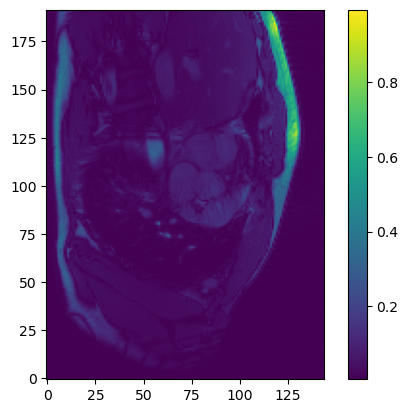

In [5]:
plt.figure()
plt.imshow(target[0,0,:,:],origin='lower')
plt.colorbar()
plt.show()

In [8]:
mask = mask_prob(target, fix=8, other=16, fft_input=False, roll=False)

In [10]:
def kplot(y,roll=False,log=False,cmap=None,flip=True,img_name=None):
    '''
    This function plots the reconstructed image.
    -- Options:
    roll: whether to move low frequencies in the middle of the Image
    log : whether to show the image in log scale
    cmap: color map choice for the plot
    '''
    if isinstance(y,torch.Tensor):
        y = y.numpy()
    yshape = y.shape
    if len(yshape)==3: # one complex-valued image
        if yshape[-1]==1 and np.iscomplex(y).any(): # complex number input
            ynew = np.zeros((yshape[0],yshape[1],2))
            ynew[:,:,0] = np.real(y[:,:,0])
            ynew[:,:,1] = np.imag(y[:,:,0])
            y           = ynew
            yshape      = y.shape
        if log:
            im1 = np.log( np.absolute(y[:,:,0]) )
            if yshape[-1] == 2:
                im2 = np.log( np.absolute(y[:,:,1]) )
        else:
            im1 = y[:,:,0]
            if yshape[-1] == 2:
                im2 = y[:,:,1]
        if roll:
            im1 = np.roll(im1,tuple(n//2 for n in im1.shape[:2]), axis=(0,1))  # move the center frequency to the center of the image
            if yshape[-1] == 2:
                im2 = np.roll(im2,tuple(n//2 for n in im2.shape[:2]), axis=(0,1))
        if yshape[-1] == 2:
            fig,axs = plt.subplots(2,1,figsize=(15,10))
            hd1 = axs[0].imshow(im1,cmap=cmap,origin='lower')
            axs[0].set_title('Real part mag')
            plt.colorbar(hd1,ax=axs[0])
            hd2 = axs[1].imshow(im2,cmap=cmap,origin='lower')
            axs[1].set_title('Imag part mag')
            fig.colorbar(hd2,ax=axs[1])
            plt.show()
        else:
            fig,axs = plt.subplots(1,1,figsize=(5,5))
            hd1 = axs.imshow(im1,cmap=cmap,origin='lower')
            # axs.set_title('Real part mag')
            plt.colorbar(hd1,ax=axs)
            plt.show()
        if img_name is not None:
            axs.set_title(img_name)
    elif len(yshape)==2: # one real-valued image
        fig,axs = plt.subplots(1,1,figsize=(10, 10))
        if roll:
            y = np.roll(y,tuple(n//2 for n in y.shape[:2]), axis=(0,1))  # move the center frequency to the center of the image
        if not log:
            try:
                hd1 = axs.imshow(y,cmap=cmap,origin='lower')
            except TypeError:
                hd1 = axs.imshow(np.abs(y),cmap=cmap,origin='lower')
        else:
            try:
                hd1 = axs.imshow(np.log(y),cmap=cmap,origin='lower')
            except TypeError:
                hd1 = axs.imshow(np.log(np.abs(y)),cmap=cmap,origin='lower')
        if img_name is not None:
            axs.set_title(img_name)
        plt.colorbar(hd1,ax=axs)
        plt.show()
    elif len(yshape)==1: # mask
        fig,axs = plt.subplots(1,1,figsize=(5, 5))
        if roll:
            y = np.roll(y,yshape[0]//2,axis=0)
        mask    = np.reshape(y,(-1,1))
        mask2D  = np.tile(mask,(1,mask.size))
        if flip:
            hd1 = axs.imshow(1-mask2D,cmap='Greys',origin='lower')
        else:
            hd1 = axs.imshow(mask2D,cmap='Greys',origin='lower')
        axs.set_xticks([])
        axs.set_xticks([], minor=True) # for minor ticks
        axs.set_ylabel('Frequencies')
        if not flip:
            plt.colorbar(hd1,ax=axs)
        if img_name is not None:
            axs.set_title(img_name)
        plt.rcParams.update({'font.size': 25})
        plt.show()

In [ ]:
def mask_prob(imgs,fix=10,other=30,roll=True,fft_input=True):
    '''
    input imgs: [NCHW]
    '''
    fix   = int(fix)
    other = int(other)
    [N,C,_,sampdim] = imgs.shape
    if not fft_input:
        y = F.fftn(imgs,dim=(2,3),norm='ortho')
    p = torch.sum(torch.abs(y),axis=(0,1,2))/(N*C)
    fixInds  = np.concatenate((np.arange(0,round(fix//2) ),np.arange(sampdim-1,sampdim-1-round(fix/2),-1)))
    p[fixInds] = 0
    p = p/p.sum() # normalize probability vector
    addInds  = np.random.choice(np.arange(sampdim),size=other,replace=False,p=p.numpy())
    maskInds = np.concatenate((fixInds,addInds))
    mask     = np.zeros(sampdim)
    mask[maskInds]= 1
    if roll:
        mask = np.roll(mask,shift=sampdim//2,axis=0)
    return mask

In [ ]:
mask = mask_naiveRand(144,fix=10,other=26,roll=False)

In [ ]:
fft_recon_img = fft_observe(target, mask, return_opt='img')

In [ ]:
plt.figure()
plt.imshow(torch.abs(fft_recon_img[0,0,:,:]),origin='lower')
error = torch.norm(torch.abs(fft_recon_img[0,0,:,:]) - target[0,0,:,:])/torch.norm(target[0,0,:,:]) 
plt.colorbar()
plt.title(f'Rel. L2 error: {error*100:.2f}%')
plt.show()

In [ ]:
from unet.unet_model_fbr import Unet
unet = Unet(in_chans=2,out_chans=1,chans=64,num_pool_layers=6,drop_prob=0)

In [ ]:
unet_path = '/home/ec2-user/SageMaker/RLsamp/output/recon_models/unet_fbr_2_chans_64base10_budget26.pt'
checkpoint = torch.load(unet_path)
unet.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unet_path )

In [ ]:
fft_recon_img = fft_observe(target, mask, return_opt='img', abs_opt=False)
fft_recon_img.shape

In [ ]:
unet_recon = unet(fft_recon_img).detach().cpu()

In [ ]:
plt.figure()
plt.imshow(unet_recon[0,0,:,:],origin='lower')
error = torch.norm(torch.abs(unet_recon[0,0,:,:]) - target[0,0,:,:])/torch.norm(target[0,0,:,:]) 
plt.colorbar()
plt.title(f'Rel. L2 error: {error*100:.2f}%')
plt.show()

In [ ]:
recon_fft = torch.abs(F.ifftn(F.ifftshift(curr_obs,dim=(2,3)),dim=(2,3),norm='ortho'))
# recon_fft = fft_observe(target, mask, return_opt='img')

In [ ]:
plt.figure()
recon_error = torch.norm(recon_fft - target)/torch.norm(target)
plt.title(f'recon L2 error is {recon_error*100:.2f}%')
plt.imshow(recon_fft[0,0,:,:],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
recon_obs = sigpy_solver(curr_obs,max_iter=50, L=5e-3)
plt.figure()
recon_error = torch.norm(recon_obs - target)/torch.norm(target)
plt.title(f'recon L2 error is {recon_error*100:.2f}%')

plt.imshow(torch.abs(recon_obs[0,0,:,:]),origin='lower')
plt.colorbar()
plt.show()

## Net and reconstructor preparation

In [ ]:
import models
reload(models)
from models import poly_net

In [ ]:
net = poly_net(samp_dim=144)
net

In [ ]:
img = torch.rand(2,3,193,144)
net(img).shape

In [ ]:
plt.figure()
plt.imshow(img[0][0],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
lowfreqmask.shape

In [ ]:
lowfreqmask,_,_ = mask_naiveRand(144,fix=10,other=4,roll=False)
img_crude       = fft_observe(img,lowfreqmask)
plt.figure()
plt.imshow(img_crude[0][0],origin='lower')
plt.colorbar()
plt.show()
print(f'error = { (torch.norm(img_crude[0][0]-img[0][0])/torch.norm(img[0][0])).item():.4f}')

In [ ]:
kin = fft_observe(img,lowfreqmask,return_opt='freq')
plt.figure()
plt.imshow(torch.log(torch.abs(kin[0][0])),origin='lower')
plt.colorbar()
plt.show()

In [ ]:
x_sigpy = sigpy_solver(kin[:,0:1,:,:],L=5e-3,solver='ADMM')
plt.figure()
plt.imshow(x_sigpy[0,0,:,:],origin='lower')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(img[0][0],origin='lower')
plt.colorbar()
plt.show()
err = torch.norm(x_sigpy[0,0,:,:]-img[0][0],p='fro')/torch.norm(img[0][0],p='fro')
print(f'error = { err.item():.4f}')

## learning with memory replay

In [ ]:
dim = 100
mask = torch.zeros(dim)
mask[np.random.permutation(dim)[0:60]] = 1
(mask==0).nonzero(as_tuple=True)[0]

In [ ]:
a = torch.randn((2,1))
a.mean().item()

In [ ]:
class RL_trainer():
    def __init__(self,dataloader,policy,memory,episodes:int=10,eps:float=1e-3,
                 fulldim:int=144,base:int=10,budget:int=50):
        self.dataloader = dataloader
        self.dataloader.reset()
        
        self.policy   = policy
        self.memory   = memory
        self.episodes = episodes
        self.epi = 0
        self.fulldim = fulldim
        self.base = base
        self.budget = budget
        self.eps = eps
        self.training_record = {'loss':[],'grad_norm':[],'q_values_mean':[],'q_values_std':[]}
        self.steps = 1
    def train(self):      
        # run training
        while self.epi < self.episodes:
            print(f'episode {self.epi:.3d} / {self.episodes}')
            mask = mask_naiveRand(self.fulldim,fix=self.base,other=0,roll=False)   # one mask at a time
            while mask.sum() < self.budget + self.base:
                data_source, data_target = self.dataloader.load()
#                 epsilon = _get_epsilon(steps_epsilon, self.options)
                curr_obs = fft_observe(data_source,mask)
                action   = self.policy.get_action(data_source, mask=mask, eps_threshold=self.eps)
                next_obs, reward = self.policy.step(action, data_target, mask)
                self.memory.push(curr_obs, action, next_obs, reward)
                
                ### compare with random policy
                with torch.no_grad():
                    action_rand = self.policy.get_rand_action(mask=mask)
                    _, reward_rand = self.policy.step(action_rand, data_target, mask)
                ########################################################################
                update_results = self.policy.update_parameters()
                if update_results is not None:
                    for key in self.training_record.keys():
                        self.training_record[key].append(update_results[key])
                    curr_loss = update_results['loss']
                    print(f'step: {self.steps:5d}, loss: {curr_loss:.4f}, RL reward: {reward.mean().item():.4f}, Rand reward: {reward_rand.mean().item():.4f}')
                    torch.cuda.empty_cache()
                self.steps += 1
#                 if self.steps % self.options.target_net_update_freq == 0:
#                     self.logger.info("Updating target network.")
#                     self.target_net.load_state_dict(self.policy.state_dict())
            self.dataloader.reset()
            self.epi += 1

In [ ]:
import dqn
reload(dqn)
from dqn import DQN

import replay_buffer
reload(replay_buffer)
from replay_buffer import *

In [ ]:
memory = ReplayMemory(capacity=10,curr_obs_shape=(3,192,144),next_obs_shape=(1,192,144),batch_size=2,burn_in=2)
model  = poly_net(samp_dim=144)
policy = DQN(model,memory)
trainer = RL_trainer(loader,policy,memory)

In [ ]:
trainer.train()

## view data

In [ ]:
'''
[kx, ky, kz, coil, phase, set, slice, rep, avg], 
frequency encoding, first phase encoding, second phase encoding, 
coil, phase (time), set (velocity encoding), slice, repetition, and number of averages

better not to take average over the repetition dimension
'''

In [ ]:
datapath = '/mnt/shared_a/OCMR/OCMR_data_fully_sampled/'
h5files = list([])
for file in os.listdir(datapath):
    if file.endswith(".h5"):
        h5files.append(file)
print(len(h5files))

In [ ]:
regular_files = []
for file in h5files:
    kData,param = read.read_ocmr(datapath+file)
    print('filename', file, 'Dimension of kData: ', kData.shape)
    curr_shape = kData.shape
    if curr_shape[0]==384 and curr_shape[1]==144:
        regular_files.append([file, curr_shape])
#     print('Scan paramters:')
#     pprint.pprint(param)

In [ ]:
path = '/home/huangz78/rl_samp/useful_files.npz'
# np.savez(path,files=regular_files)

In [ ]:
data = np.load(path,allow_pickle=True)
data['files']

In [ ]:
file = 'fs_0074_1_5T.h5'
kData,param = read.read_ocmr(datapath+file)

In [ ]:
# Image reconstruction (SoS)
dim_kData = kData.shape
print('Dimension of kData: ', dim_kData)
CH  = dim_kData[3]
SLC = dim_kData[6]
print('SLC: ', SLC)
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1, avg dimension is reduced

im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]); # IFFT (2D image)
im_sos  = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)) # Sum of Square, coil dimension is reduced
print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
RO    = im_sos.shape[0]

# breakpoint()
image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:] # Remove RO oversampling
print('Dimension of Image (without ReadOout ovesampling): ', image.shape)

In [ ]:
print('image sos shape',im_sos.shape)
im_sos_slice = im_sos[:,:,0,0,0,0,0]

In [ ]:
kslice = kData_tmp[:,:,0,0,0,0,0,0]

In [ ]:
im_sos_slice[0,:10]

In [ ]:
# coil_ind = 19
# print(im_coil.shape)
# im_slice = im_coil[:,:,0,coil_ind,0,0,0,0]

plt.figure()
plt.imshow(image[:,:,0,0,0,0,0],origin='lower')
# plt.imshow(np.abs(im_slice),origin='lower')
# plt.imshow(np.log(np.abs(kslice)),origin='lower')
plt.colorbar()
plt.show()

In [ ]:
image_slc.shape[2]

In [ ]:
# Show the reconstructed cine image
from IPython.display import clear_output
import time

slc_idx = 2 # math.floor(SLC/2)
print(slc_idx)
image_slc = np.squeeze(image[:,:,:,:,:,slc_idx,:])/image[:,:,:,:,:,slc_idx,:].max()
print(image_slc.shape)
# image_slc = np.squeeze(image[:,:,:,:,:,:,slc_idx])
for rep in range(5): # repeate the movie for 5 times
    for frame in range(image_slc.shape[2]):
        clear_output(wait=True)
        plt.imshow(image_slc[:,:,frame], vmin=0, vmax=0.6*np.amax(image_slc), cmap = 'gray',origin='lower')
        plt.axis('off')
        plt.colorbar()
        plt.show() 
        time.sleep(0.03)

In [ ]:
savepath = '/mnt/shared_a/OCMR/OCMR_fully_sampled_images/'
for fileind in range(len(regular_files)):
    filename    = regular_files[fileind][0]
    kData,param = read.read_ocmr(datapath+file)
    kData_tmp   = np.mean(kData, axis = 8); # average the k-space if average > 1

    im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]); # IFFT (2D image)
    im_sos  = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)) # Sum of Square
    print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
    RO    = im_sos.shape[0]
    image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:] # Remove RO oversampling
    print('Dimension of Image (without ReadOout ovesampling): ', image.shape)
    
    for sliceind in range(image.shape[5]):
        image[:,:,:,:,:,sliceind,:] /= image[:,:,:,:,:,sliceind,:].max()
    
    torch.save(torch.tensor(image) , savepath + filename[:-3] + '.pt')
    print(f'file {savepath + filename} is successfully saved')

In [ ]:
datapath = '/mnt/shared_a/OCMR/OCMR_fully_sampled_images/'
file = 'fs_0074_1_5T.pt'
data = torch.load(datapath+file)

In [ ]:
slc_idx = 6 # math.floor(SLC/2)
print(slc_idx)
# image_slc = np.squeeze(image[:,:,:,:,:,slc_idx,:])/image[:,:,:,:,:,slc_idx,:].max()
# print(image_slc.shape)
# image_slc = np.squeeze(image[:,:,:,:,:,:,slc_idx])
for rep in range(3): # repeat the movie for 5 times
    for frame in range(data.shape[3]):
        clear_output(wait=True)
        plt.imshow(data[:,:,0,frame,0,slc_idx,:], vmin=0, vmax=data.max(), cmap = 'gray'); plt.axis('off');
        plt.colorbar()
        plt.show() 
        time.sleep(0.03)